## Contents
* read data
* drop redeundant columns
* one-hot encoding
* sliding window method
* identify response variable and predictors
* dimensionality reduction
* split into training and testing datasets
* data normalisation of training datasets
* define the model
* choose hyperparameters to tune
* identify the best hyperparameters using gridsearch
* make predictions based on these hyperparameters
* assess model performance 
* perform SHAP analysis

In [1]:
import os
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
import datetime as dt
import shap
import pickle
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

In [2]:
# base_dir = os.path.dirname(os.path.abspath("..\data"))
# path = os.path.join(base_dir, r"data") #.replace("\\code","")
# os.chdir(path) 

In [3]:
# data = pd.read_csv("Cleaned data\data.csv")
data = pd.read_csv("data.csv")

In [4]:
# filter date
df = data[data['DATE'] > '2018-08-01']

# drop columns
df = df.drop(columns=[
    "DATE","MONTHDATE","MIN","ACCMIN","MAX","ACCMAX","RAINPERIOD","QUANTITY","QUANTITYMONTHCUM","QUANTITYTOTALCUM","HUMIDITYMIN","HUMIDITYMAX", "RAIN", "WEEKEND"
], errors="ignore").reset_index(drop=True)
df.head()

YEAR  MONTH  DAY  HUMIDITY  WINDSPEED  TOTALDEMAND  HOLIDAY  SOLAR  \
0  2018      8    2  0.433778  16.377778  8655.004063      0.0   12.1   
1  2018      8    3  0.620851  14.829787  8353.189132      0.0   13.3   
2  2018      8    4  0.608511  20.659574  7742.749514      0.0   13.3   
3  2018      8    5  0.433333  18.488889  7645.043264      0.0   13.4   
4  2018      8    6  0.545000  15.978261  8609.566215      1.0    6.3   

   TEMPAVE        RRP  FORECASTDEMAND  OUTPUT  WEEKDAY  
0    12.55  72.961957     8302.718612  165.17        3  
1    13.75  78.868542     8129.498010  165.17        4  
2    13.65  66.300000     7133.447593  165.17        5  
3    11.65  62.830213             NaN  165.17        6  
4    11.45  82.375333     9403.610320  165.17        0

In [5]:
#one hot encoding weekday
def one_hot_encode(df, col, names):
    array = np.array(df[col])
    integer_encoded = array.reshape(len(array), 1)
    onehotencoder = OneHotEncoder()
    onehot_encoded = onehotencoder.fit_transform(integer_encoded).toarray()
    df_encoded = pd.DataFrame(onehot_encoded, columns=names)
    df = pd.concat([df, df_encoded], axis=1)
    df = df.drop(columns=[col], errors="ignore")
    return df

df = one_hot_encode(df, col="WEEKDAY", names=['MON', 'TUE', 'WED', 'THU', 'FRI', 'SAT', 'SUN'])
df.head()

YEAR  MONTH  DAY  HUMIDITY  WINDSPEED  TOTALDEMAND  HOLIDAY  SOLAR  \
0  2018      8    2  0.433778  16.377778  8655.004063      0.0   12.1   
1  2018      8    3  0.620851  14.829787  8353.189132      0.0   13.3   
2  2018      8    4  0.608511  20.659574  7742.749514      0.0   13.3   
3  2018      8    5  0.433333  18.488889  7645.043264      0.0   13.4   
4  2018      8    6  0.545000  15.978261  8609.566215      1.0    6.3   

   TEMPAVE        RRP  FORECASTDEMAND  OUTPUT  MON  TUE  WED  THU  FRI  SAT  \
0    12.55  72.961957     8302.718612  165.17  0.0  0.0  0.0  1.0  0.0  0.0   
1    13.75  78.868542     8129.498010  165.17  0.0  0.0  0.0  0.0  1.0  0.0   
2    13.65  66.300000     7133.447593  165.17  0.0  0.0  0.0  0.0  0.0  1.0   
3    11.65  62.830213             NaN  165.17  0.0  0.0  0.0  0.0  0.0  0.0   
4    11.45  82.375333     9403.610320  165.17  1.0  0.0  0.0  0.0  0.0  0.0   

   SUN  
0  0.0  
1  0.0  
2  0.0  
3  1.0  
4  0.0

In [6]:
def create_lags(df, lookback, columns):
    for col in columns:
        if col == "TOTALDEMAND":
            df["y"] = df[col].shift(-1) #response variable, total demand 1 day look ahead
        for i in range(lookback + 1):
            if i == 0: pass
            else: df[col+f" (t-{i})"] = df[col].shift(i) #i day/s look back 
    return df 

In [7]:
# get lag variables
lookback = 7 #day/s 
columns = ["HUMIDITY","WINDSPEED","HOLIDAY","TOTALDEMAND","SOLAR","RRP","OUTPUT","TEMPAVE"]
df_lagged = df.copy()
df_lagged = create_lags(df_lagged, lookback, columns)
df_lagged[columns] = df_lagged[columns].dropna()
print(len(df_lagged.columns))
df_lagged.head()

76


YEAR  MONTH  DAY  HUMIDITY  WINDSPEED  TOTALDEMAND  HOLIDAY  SOLAR  \
0  2018      8    2  0.433778  16.377778  8655.004063      0.0   12.1   
1  2018      8    3  0.620851  14.829787  8353.189132      0.0   13.3   
2  2018      8    4  0.608511  20.659574  7742.749514      0.0   13.3   
3  2018      8    5  0.433333  18.488889  7645.043264      0.0   13.4   
4  2018      8    6  0.545000  15.978261  8609.566215      1.0    6.3   

   TEMPAVE        RRP  FORECASTDEMAND  OUTPUT  MON  TUE  WED  THU  FRI  SAT  \
0    12.55  72.961957     8302.718612  165.17  0.0  0.0  0.0  1.0  0.0  0.0   
1    13.75  78.868542     8129.498010  165.17  0.0  0.0  0.0  0.0  1.0  0.0   
2    13.65  66.300000     7133.447593  165.17  0.0  0.0  0.0  0.0  0.0  1.0   
3    11.65  62.830213             NaN  165.17  0.0  0.0  0.0  0.0  0.0  0.0   
4    11.45  82.375333     9403.610320  165.17  1.0  0.0  0.0  0.0  0.0  0.0   

   SUN  HUMIDITY (t-1)  HUMIDITY (t-2)  HUMIDITY (t-3)  HUMIDITY (t-4)  \
0  0.0             NaN             NaN             NaN             NaN   
1  0.0        0.433778             NaN             NaN             NaN   
2  0.0        0.620851        0.433778             NaN             NaN   
3  1.0        0.608511        0.620851        0.433778             NaN   
4  0.0        0.433333        0.608511        0.620851        0.433778   

   HUMIDITY (t-5)  HUMIDITY (t-6)  HUMIDITY (t-7)  WINDSPEED (t-1)  \
0             NaN             NaN             NaN              NaN   
1             NaN             NaN             NaN        16.377778   
2             NaN             NaN             NaN        14.829787   
3             NaN             NaN             NaN        20.659574   
4             NaN             NaN             NaN        18.488889   

   WINDSPEED (t-2)  WINDSPEED (t-3)  WINDSPEED (t-4)  WINDSPEED (t-5)  \
0              NaN              NaN              NaN              NaN   
1              NaN              NaN              NaN              NaN   
2        16.377778              NaN              NaN              NaN   
3        14.829787        16.377778              NaN              NaN   
4        20.659574        14.829787        16.377778              NaN   

   WINDSPEED (t-6)  WINDSPEED (t-7)  HOLIDAY (t-1)  HOLIDAY (t-2)  \
0              NaN              NaN            NaN            NaN   
1              NaN              NaN            0.0            NaN   
2              NaN              NaN            0.0            0.0   
3              NaN              NaN            0.0            0.0   
4              NaN              NaN            0.0            0.0   

   HOLIDAY (t-3)  HOLIDAY (t-4)  HOLIDAY (t-5)  HOLIDAY (t-6)  HOLIDAY (t-7)  \
0            NaN            NaN            NaN            NaN            NaN   
1            NaN            NaN            NaN            NaN            NaN   
2            NaN            NaN            NaN            NaN            NaN   
3            0.0            NaN            NaN            NaN            NaN   
4            0.0            0.0            NaN            NaN            NaN   

             y  TOTALDEMAND (t-1)  TOTALDEMAND (t-2)  TOTALDEMAND (t-3)  \
0  8353.189132                NaN                NaN                NaN   
1  7742.749514        8655.004063                NaN                NaN   
2  7645.043264        8353.189132        8655.004063                NaN   
3  8609.566215        7742.749514        8353.189132        8655.004063   
4  8634.633681        7645.043264        7742.749514        8353.189132   

   TOTALDEMAND (t-4)  TOTALDEMAND (t-5)  TOTALDEMAND (t-6)  TOTALDEMAND (t-7)  \
0                NaN                NaN                NaN                NaN   
1                NaN                NaN                NaN                NaN   
2                NaN                NaN                NaN                NaN   
3                NaN                NaN                NaN                NaN   
4        8655.004063            

In [8]:
# define X matrix and response variable
y = df_lagged[["y"]]
X = df_lagged.drop(columns=["y"], axis=1, errors="ignore")
X_all = X.copy() #save for accuracy plotting
X = X.drop(["FORECASTDEMAND","TOTALDEMAND","TOTALDEMAND (t-1)","TOTALDEMAND (t-2)","TOTALDEMAND (t-3)","TOTALDEMAND (t-4)","TOTALDEMAND (t-5)","TOTALDEMAND (t-6)","TOTALDEMAND (t-7)"],axis=1)
# print(X.head())

In [9]:
# train test split - use last year to train (data ends in 08/2022 so set timeframe as 08/2021 to 08/2022)
test_timeframe = df.loc[np.where(((df['YEAR'] == 2021) & (df['MONTH'] > 7)) | (df['YEAR'] == 2022))]
test_len = len(test_timeframe) 
X_train, X_test = X.head(len(X)-test_len), X.tail(test_len)
y_train, y_test = y.head(len(X)-test_len), y.tail(test_len)
SHAP_cols = X_train.columns #save for later analysis

In [10]:
# define scaler and transform data
scaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train))
X_test_scaled = pd.DataFrame(scaler.fit_transform(X_test))

In [11]:
# Define the XGBoost model 
model = xgb.XGBRegressor() 

In [12]:
# # hyperparameters (allowed ranges noted) 
# params = {
#     'colsample_bytree': [0.8, 0.9, 1], #(0,1]
#     'gamma': [0, 0.01, 0.1, 0.5, 0.9], #[0,1]
#     'learning_rate': [0.05, 0.06, 0.07], #[0,1]
#     'n_estimators': [120, 150, 160, 170, 180], #[0,inf]
#     'reg_alpha': [1, 2, 3, 4, 5, 6], #[0,inf]
#     'reg_lambda': [1, 2, 3, 4, 5], #[1,inf]
#     'subsample': [0.2, 0.3, 0.4, 0.8, 1], #(0,1] 
# } 

In [13]:
# hyperparameters (allowed ranges noted) 
params = {
    'colsample_bytree': [0.7], #(0,1]
    'gamma': [0.7], #[0,1]
    'learning_rate': [0.05], #[0,1]
    'n_estimators': [310], #[0,inf]
    'reg_alpha': [20], #[0,inf]
    'reg_lambda': [1], #[1,inf]
    'subsample': [0.9], #(0,1] 
} 

In [14]:
# identify best hyperparameters using gridsearch 
grid = GridSearchCV(model, params, cv=3, n_jobs=-1) 
grid.fit(X_train_scaled, y_train) 

GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estim

In [15]:
# best hyperparameters and score 
print("Best Hyperparameters: ", grid.best_params_) 
print("Best Score: ", grid.best_score_) 

Best Hyperparameters:  {'colsample_bytree': 0.7, 'gamma': 0.7, 'learning_rate': 0.05, 'n_estimators': 310, 'reg_alpha': 20, 'reg_lambda': 1, 'subsample': 0.9}
Best Score:  0.6714046442049785


In [16]:
# # print all results 
# print("------ All Results ------- ")
# means = grid.cv_results_['mean_test_score']
# stds = grid.cv_results_['std_test_score']
# for mean, std, params in zip(means, stds, grid.cv_results_['params']):
#     print("   %0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
# print("------ End All Results ------- ") 

In [17]:
# train model using best hyperparameters
best_model = grid.best_estimator_
best_model.fit(X_train_scaled, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.7, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=310, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [18]:
# predictions on test data 
y_pred = best_model.predict(X_test_scaled)

In [19]:
# # # save as pickle file
# pickle.dumps(best_model, open('xgb_model.pkl', 'wb'))

#### Diagnostics and Accuracy Plots

In [20]:
df_lim = X_all.tail(test_len)
df_lim["YTEST"] = y_test
df_lim["YPRED"] = y_pred
df_lim["DATE"] = pd.to_datetime(dict(year=df.YEAR, month=df.MONTH, day=df.DAY))
df_lim["FORECAST"] = df_lim["FORECASTDEMAND"].shift(-1)
df_lim = df_lim[["DATE","TOTALDEMAND","YTEST","YPRED","FORECAST"]]
df_lim = df_lim.dropna()
df_lim = df_lim.iloc[1:,:]

In [21]:
Date = [d.date() for d in df_lim.DATE]
Forecast = df_lim.FORECAST
Pred = df_lim.YPRED
Test = df_lim.YTEST

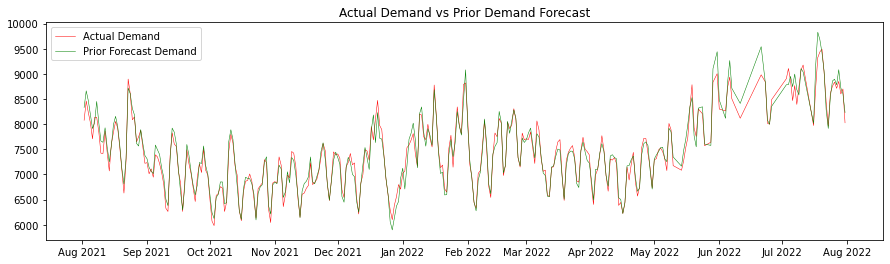

In [22]:
fig, ax = plt.subplots(figsize=(15,4))
test = ax.plot(Date, Test, linewidth=0.5, color='red')
forecast = ax.plot(Date, Forecast, linewidth=0.5, color='green')
ax.legend([test, forecast], labels=["Actual Demand", "Prior Forecast Demand"])
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax.set_title("Actual Demand vs Prior Demand Forecast")
plt.show()

In [23]:
# print prior model performance
mae1 = mean_absolute_error(Test, Forecast)
r21 = r2_score(Test, Forecast)
print("Mean Absolute Error: {:.2f}".format(mae1))
print("R Squared: {:.2f}".format(r21))

Mean Absolute Error: 112.26
R Squared: 0.96


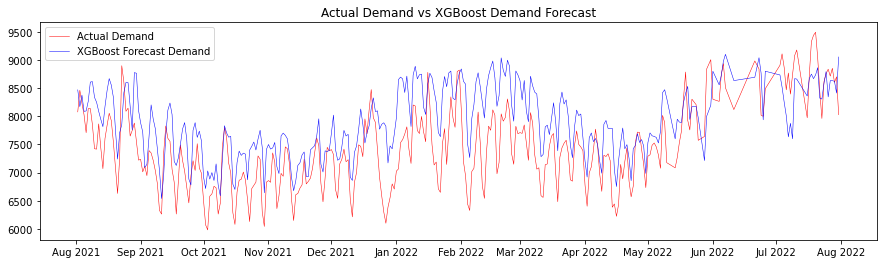

In [24]:
fig, ax = plt.subplots(figsize=(15,4)) 
test = ax.plot(Date, Test, linewidth=0.5, color='red')
forecast = ax.plot(Date, Pred, linewidth=0.5, color='blue')
ax.legend([test, forecast], labels=["Actual Demand", "XGBoost Forecast Demand"])
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax.set_title("Actual Demand vs XGBoost Demand Forecast")
plt.show() 

In [25]:
# print current model performance
mae2 = mean_absolute_error(Test, Pred)
r22 = r2_score(Test, Pred)
print("Mean Absolute Error: {:.2f}".format(mae2))
print("R Squared: {:.2f}".format(r22))

Mean Absolute Error: 565.99
R Squared: 0.15


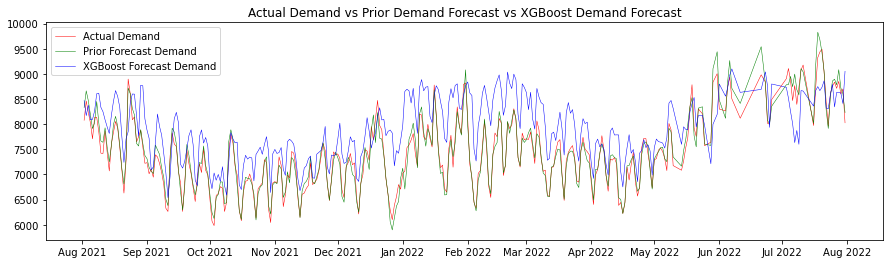

In [26]:
fig, ax = plt.subplots(figsize=(15,4))
demand_actuals = ax.plot(Date, Test, linewidth=0.5, color='red')
prior_forecast = ax.plot(Date, Forecast, linewidth=0.5, color='green')
xgb_forecast = ax.plot(Date, Pred, linewidth=0.5, color='blue')
ax.legend([demand_actuals, prior_forecast, xgb_forecast], labels=["Actual Demand", "Prior Forecast Demand", "XGBoost Forecast Demand"])
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax.set_title("Actual Demand vs Prior Demand Forecast vs XGBoost Demand Forecast")
plt.show()

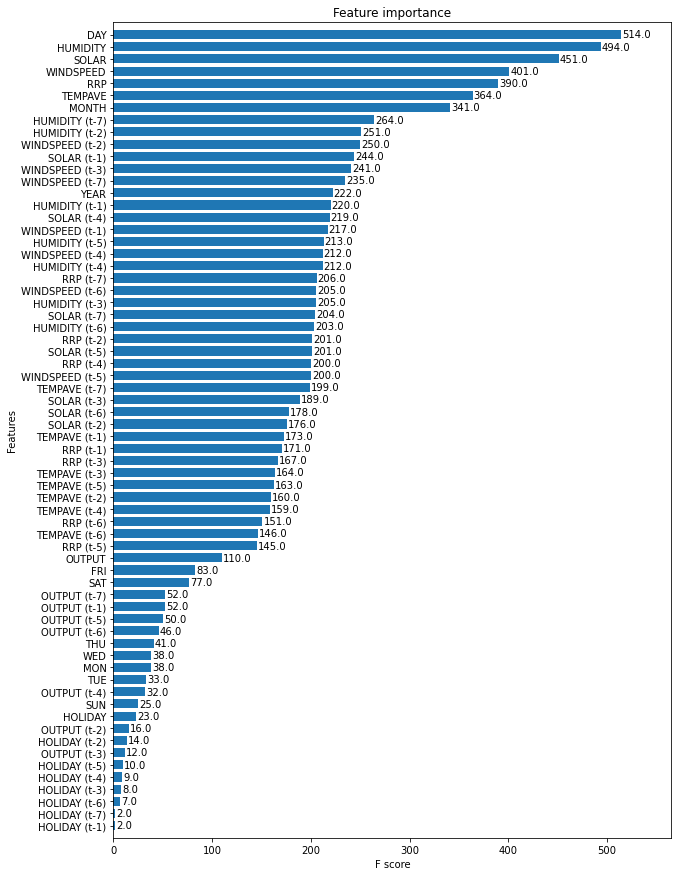

In [27]:
from xgboost import plot_importance
plt.rcParams["figure.figsize"] = (10,15)
best_model.get_booster().feature_names = list(SHAP_cols)
plot_importance(best_model.get_booster(), height = 0.75, grid = False)
plt.show()

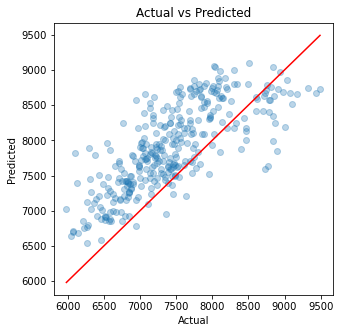

In [28]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(Test, Pred, label = 'Actual', alpha = 0.3)
ax.plot([max(max(Pred), max(Test)), min(min(Pred), min(Test))], [max(max(Pred), max(Test)), min(min(Pred), min(Test))], 'r-')
plt.title('Actual vs Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

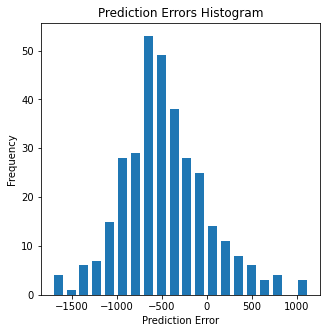

In [29]:
errors = Test - Pred
fig, ax = plt.subplots(figsize=(5,5))
ax.hist(errors, bins=20, rwidth=0.7)
ax.set_title('Prediction Errors Histogram')
ax.set_xlabel('Prediction Error')
ax.set_ylabel('Frequency')
plt.show() 

# SHAP

In [30]:
# renaming df columns to include name of feature (important for graphical representations)
X_train_scaled2 = X_train_scaled.copy()
X_train_scaled2.columns = SHAP_cols
X_train_scaled2.head()

YEAR     MONTH       DAY  HUMIDITY  WINDSPEED  HOLIDAY     SOLAR   TEMPAVE  \
0   0.0  0.636364  0.033333  0.256322   0.209256      0.0  0.355769  0.234676   
1   0.0  0.636364  0.066667  0.517525   0.165351      0.0  0.394231  0.276708   
2   0.0  0.636364  0.100000  0.500294   0.330701      0.0  0.394231  0.273205   
3   0.0  0.636364  0.133333  0.255701   0.269134      0.0  0.397436  0.203152   
4   0.0  0.636364  0.166667  0.411617   0.197925      0.5  0.169872  0.196147   

        RRP    OUTPUT  MON  TUE  WED  THU  FRI  SAT  SUN  HUMIDITY (t-1)  \
0  0.467911  0.332373  0.0  0.0  0.0  1.0  0.0  0.0  0.0             NaN   
1  0.520468  0.332373  0.0  0.0  0.0  0.0  1.0  0.0  0.0        0.256322   
2  0.408633  0.332373  0.0  0.0  0.0  0.0  0.0  1.0  0.0        0.517525   
3  0.377759  0.332373  0.0  0.0  0.0  0.0  0.0  0.0  1.0        0.500294   
4  0.551671  0.332373  1.0  0.0  0.0  0.0  0.0  0.0  0.0        0.255701   

   HUMIDITY (t-2)  HUMIDITY (t-3)  HUMIDITY (t-4)  HUMIDITY (t-5)  \
0             NaN             NaN             NaN             NaN   
1             NaN             NaN             NaN             NaN   
2        0.256322             NaN             NaN             NaN   
3        0.517525        0.256322             NaN             NaN   
4        0.500294        0.517525        0.256322             NaN   

   HUMIDITY (t-6)  HUMIDITY (t-7)  WINDSPEED (t-1)  WINDSPEED (t-2)  \
0             NaN             NaN              NaN              NaN   
1             NaN             NaN         0.209256              NaN   
2             NaN             NaN         0.165351         0.209256   
3             NaN             NaN         0.330701         0.165351   
4             NaN             NaN         0.269134         0.330701   

   WINDSPEED (t-3)  WINDSPEED (t-4)  WINDSPEED (t-5)  WINDSPEED (t-6)  \
0              NaN              NaN              NaN              NaN   
1              NaN              NaN              NaN              NaN   
2              NaN              NaN              NaN              NaN   
3         0.209256              NaN              NaN              NaN   
4         0.165351         0.209256              NaN              NaN   

   WINDSPEED (t-7)  HOLIDAY (t-1)  HOLIDAY (t-2)  HOLIDAY (t-3)  \
0              NaN            NaN            NaN            NaN   
1              NaN            0.0            NaN            NaN   
2              NaN            0.0            0.0            NaN   
3              NaN            0.0            0.0            0.0   
4              NaN            0.0            0.0            0.0   

   HOLIDAY (t-4)  HOLIDAY (t-5)  HOLIDAY (t-6)  HOLIDAY (t-7)  SOLAR (t-1)  \
0            NaN            NaN            NaN            NaN          NaN   
1            NaN            NaN            NaN            NaN     0.355769   
2            NaN            NaN            NaN            NaN     0.394231   
3            NaN            NaN            NaN            NaN     0.394231   
4            0.0            NaN            NaN            NaN     0.397436   

   SOLAR (t-2)  SOLAR (t-3)  SOLAR (t-4)  SOLAR (t-5)  SOLAR (t-6)  \
0          NaN          NaN          NaN          NaN          NaN   
1          NaN          NaN          NaN          NaN          NaN   
2     0.355769          NaN          NaN          NaN          NaN   
3     0.394231     0.355769          NaN          NaN          NaN   
4     0.394231     0.394231     0.355769          NaN          NaN   

   SOLAR (t-7)  RRP (t-1)  RRP (t-2)  RRP (t-3)  RRP (t-4)  RRP (t-5)  \
0          NaN        NaN        NaN        NaN        NaN        NaN   
1          NaN   0.467911        NaN        NaN        NaN        NaN   
2          NaN   0.520468   0.467911        NaN        NaN        NaN   
3          NaN   0.408633   0.520468   0.467911        NaN        NaN   
4          NaN   0.377759   0.408633   0.520468   0.467911        NaN   

   RRP (t-6)  RRP (t-7)  OUTPUT (t-1)  OUTPUT 

#### Explain predictions

In [31]:
# explain the model's predictions using SHAP values 
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_train_scaled2)

#### Visualise a single preduction

In [32]:
# visualise the first prediction's explanation
shap.initjs() 
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train_scaled2.iloc[0,:])

The above explanation shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the model output. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue.

#### Visualise many predictions

In [33]:
# visualize the training set predictions
shap.force_plot(explainer.expected_value, shap_values, X_train_scaled2)

To understand how a single feature effects the output of the model we can plot the SHAP value of that feature vs. the value of the feature for all the examples in a dataset. SHAP values represent a feature's responsibility for a change in the model output. Vertical dispersion represents interaction effects with other features. To help reveal these interactions dependence_plot automatically selects another feature for coloring.

#### SHAP Summary Plot (bee-swarm plot)

Provides a density scatter plot of SHAP values for each feature to identify how much impact each featyre has on the model output for the validation dataset. Features are sorted by the sum of the SHAP value magnitudes. Note, when the scatter points don't fit on a line they pile up to show density, and the colour of each point represents the feature value of that point.

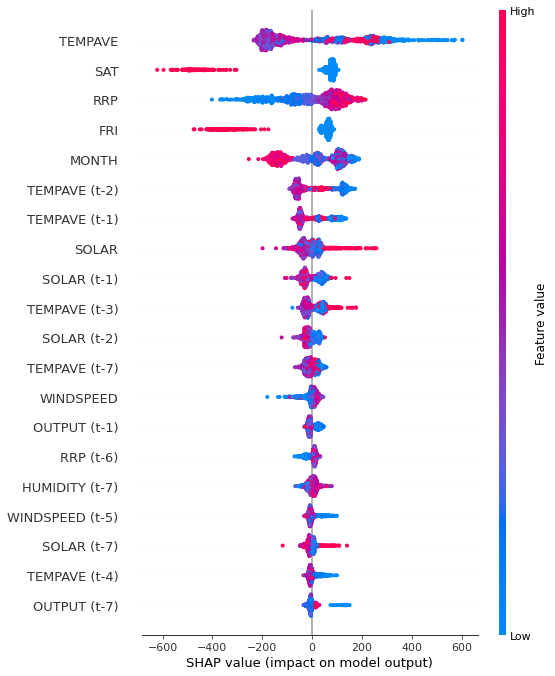

In [34]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_train_scaled2)

#### Bar chart of mean importance

We can also just take the mean absolute value of the SHAP values for each feature to get a standard bar plot (produces stacked bars for multi-class outputs).

This takes the average of the SHAP value magnitudes across the dataset and plots it as a simple bar chart.

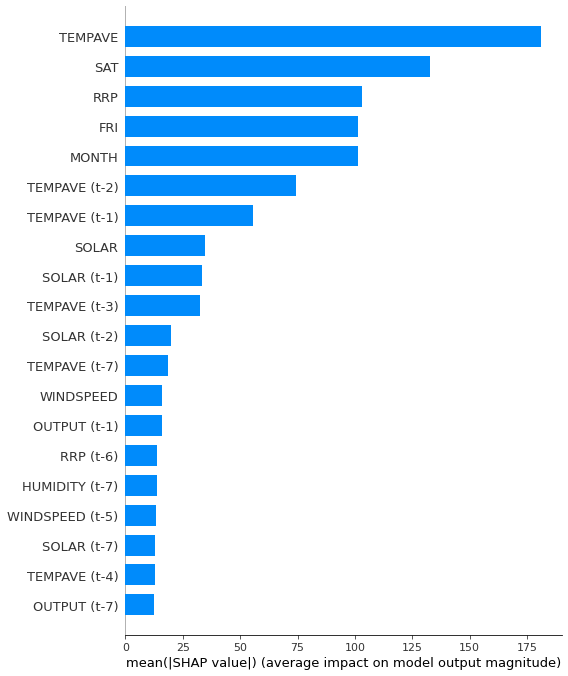

In [35]:
shap.summary_plot(shap_values, X_train_scaled2, plot_type="bar")

#### SHAP Dependence Plots

SHAP dependence plots show the effect of a single feature across the whole dataset. They plot a feature’s value vs. the SHAP value of that feature. SHAP dependence plots are similar to partial dependence plots, but account for the interaction effects present in the features, and are only defined in regions of the input space supported by data. The vertical dispersion of SHAP values at a single feature value is driven by interaction effects, and another feature is chosen for coloring to highlight possible interactions.

In [36]:
# for name in X_train_scaled2.columns:
#     shap.dependence_plot(name, shap_values, X_train_scaled2)

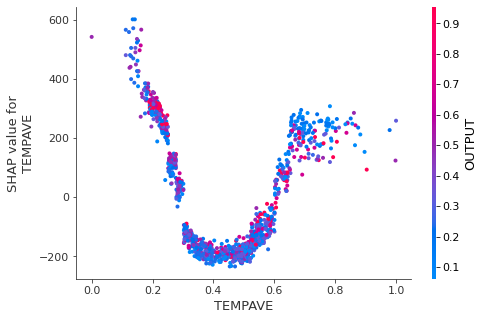

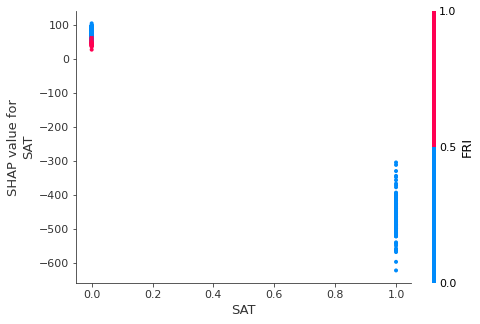

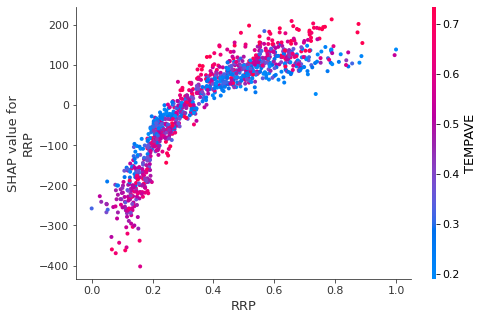

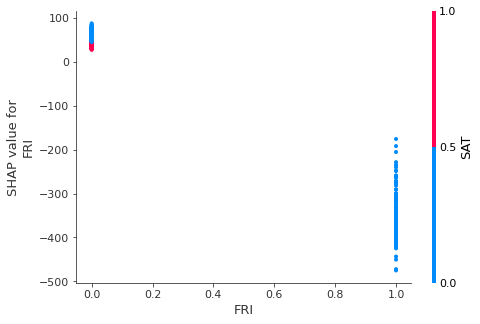

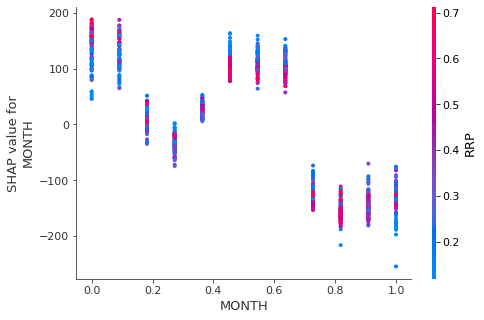

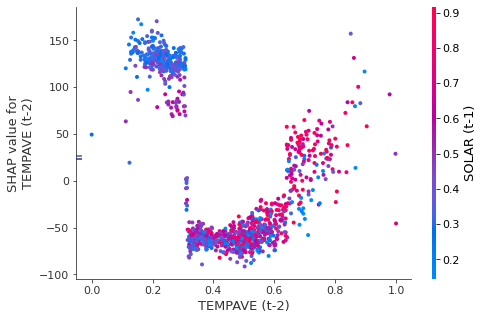

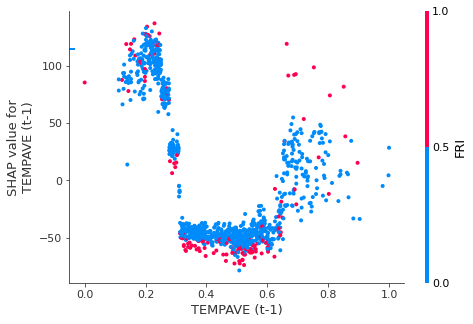

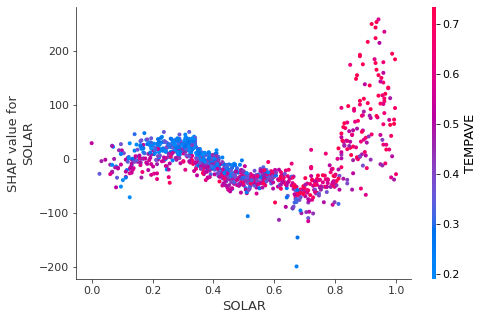

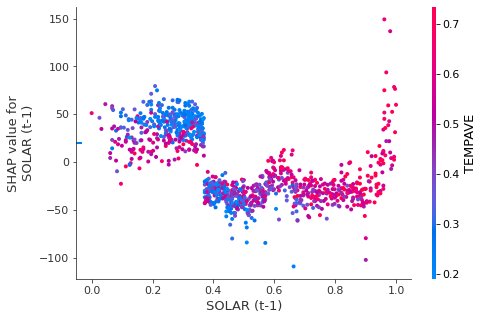

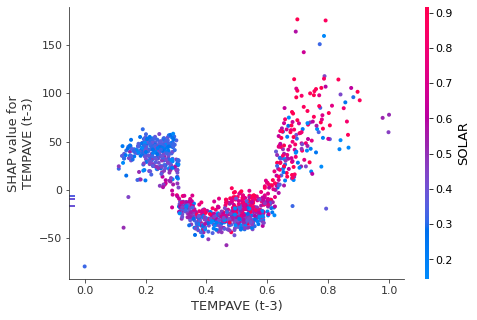

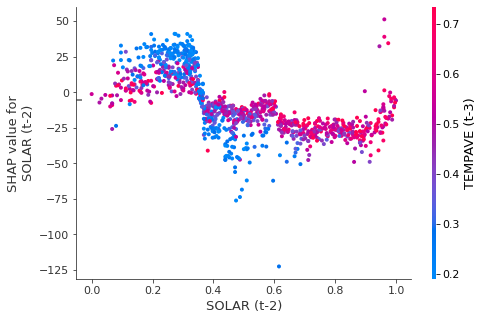

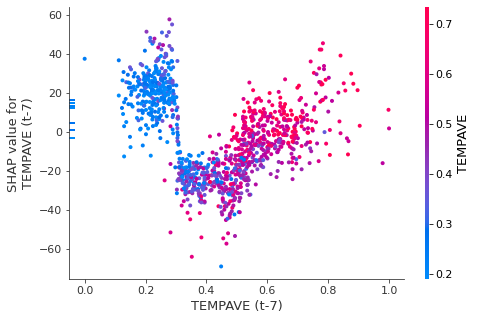

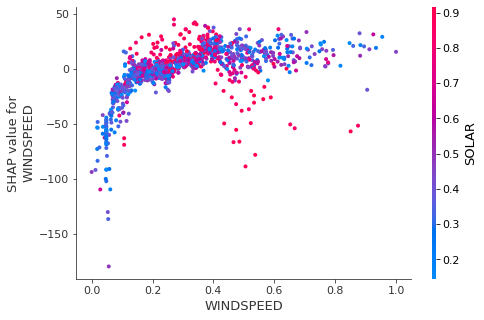

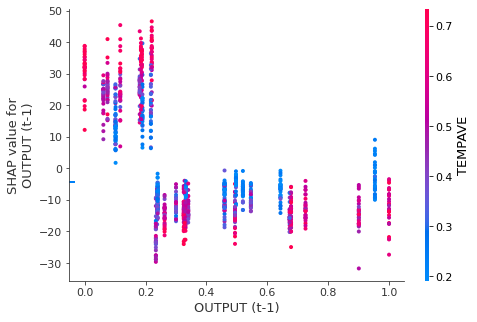

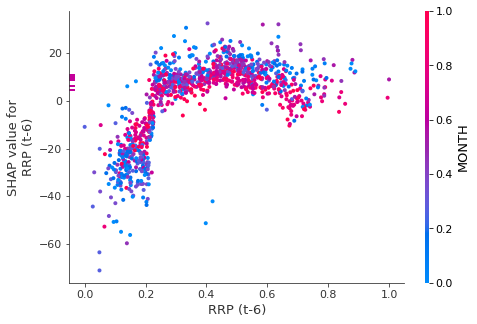

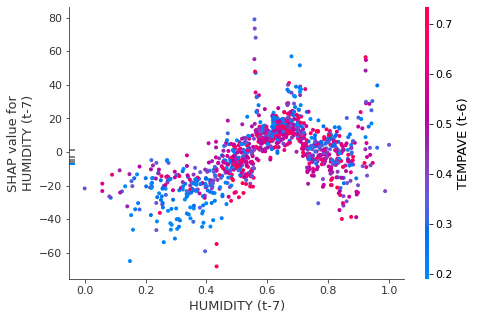

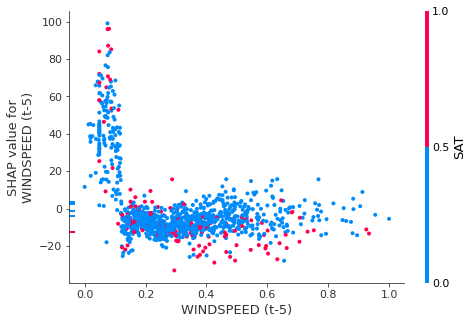

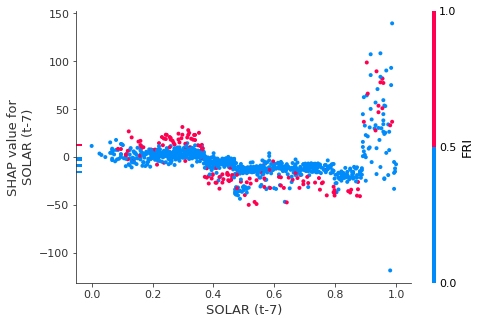

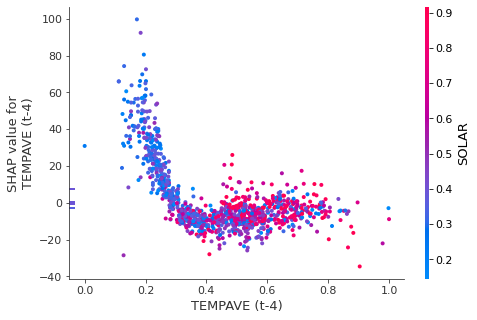

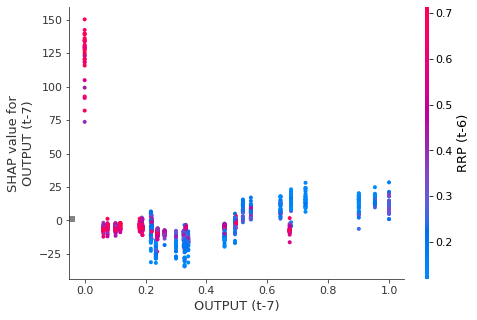

In [40]:
# sort the features indexes by their importance in the model
# (sum of SHAP value magnitudes over the validation dataset)
top_inds = np.argsort(-np.sum(np.abs(shap_values), 0))

# make SHAP plots of the top X most important features
for i in range(20):
    shap.dependence_plot(top_inds[i], shap_values, X_train_scaled2)

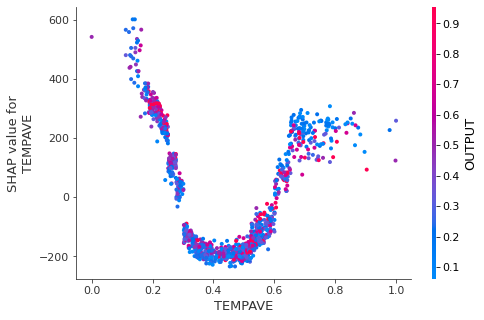

In [38]:
# TEMPAVE
shap.dependence_plot("TEMPAVE", shap_values, X_train_scaled2)

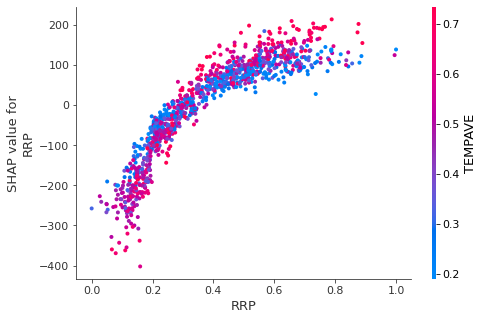

In [41]:
# RRP
shap.dependence_plot("RRP", shap_values, X_train_scaled2)

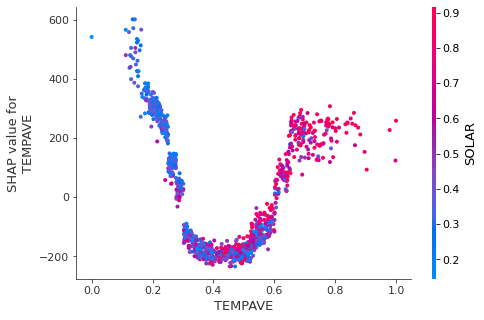

In [39]:
# TOTALDEMAND v TEMPAVE
shap.dependence_plot("TEMPAVE", shap_values, X_train_scaled2, interaction_index="SOLAR")

The dependence plot for the top feature, TOTALDEMAND, shows that XGBoost captured most of the linear relationship. It is important to note that XGBoost is biased towards flat regions, which can be seen above by the slightly flatten tails of the linear function.